<a href="https://colab.research.google.com/github/antonychackotc/project-1/blob/main/abc_rfm-analysing_retail_order_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ABC INVENTORY based of RFM analysis**

In [273]:
import sqlite3
import pandas as pd

# File name of the uploaded CSV
csv_filename = "/content/cleaned-orders-1.csv"  # Replace this with the uploaded file name

# Load CSV into a pandas DataFrame
df = pd.read_csv(csv_filename)

# Connect to SQLite database (or create a new one)
conn = sqlite3.connect("example.db")
cursor = conn.cursor()

# Write DataFrame to SQLite table
table_name = "cleanedorders1"  # Specify your table name
df.to_sql(table_name, conn, if_exists="replace", index=False)

print(f"Table '{table_name}' created in SQLite database.")

Table 'cleanedorders1' created in SQLite database.


# **1)Sales**

In [274]:
# Rank A - Selling Price - 10000 to 20000
# Rank B - Selling Price - 5000 to 9999
# Rank C - Selling Price - 1000 to 4999
# Rank D - Selling Price - 500 to 999
# Rank E - Selling Price - 200 to 499
# Rank F - Selling Price - 1 to 199
# Rank G - Selling Price - 0 to -5

In [275]:
query = f"SELECT Selling_Price, CASE  WHEN AVG(Selling_Price) BETWEEN 10000 AND 20000 THEN 'A' WHEN AVG(Selling_Price) BETWEEN 5000 AND 9999 THEN 'B' WHEN AVG(Selling_Price) BETWEEN 1000 AND 4999 THEN 'C' WHEN AVG(Selling_Price) BETWEEN 500 AND 999  THEN 'D' WHEN AVG(Selling_Price) BETWEEN 200 AND 499 THEN 'E' WHEN AVG(Selling_Price) BETWEEN 1 AND 199 THEN 'F' ELSE 'G' END AS class_sales FROM {table_name} GROUP BY Selling_Price;"
result = pd.read_sql_query(query, conn)

# Display the results
result

,Selling_Price,class_sales
0,0.0,G
1,9.5,F
2,9.6,F
3,9.7,F
4,9.8,F
...,...,...
695,9975.0,B
696,10976.0,A
697,13440.0,A
698,16975.0,A


In [276]:
alter_query = f"""
ALTER TABLE {table_name} ADD COLUMN class_sales TEXT;
"""

# Execute the query to alter the table
cursor = conn.cursor()

try:
    cursor.execute(alter_query)
    conn.commit()
    print("Column 'class_sales' added successfully.")
except sqlite3.OperationalError as e:
    if "duplicate column name" in str(e):
        print("Column 'class_sales' already exists in the table.")
    else:
        raise e  # Re-raise the exception if it's not a duplicate column error

Column 'class_sales' added successfully.


In [277]:
update_query = f"""
WITH sales_classification AS (
    SELECT Selling_Price,
           CASE
               WHEN AVG(Selling_Price) BETWEEN 10000 AND 20000 THEN 'A'
               WHEN AVG(Selling_Price) BETWEEN 5000 AND 9999 THEN 'B'
               WHEN AVG(Selling_Price) BETWEEN 1000 AND 4999 THEN 'C'
               WHEN AVG(Selling_Price) BETWEEN 500 AND 999 THEN 'D'
               WHEN AVG(Selling_Price) BETWEEN 200 AND 499 THEN 'E'
               WHEN AVG(Selling_Price) BETWEEN 1 AND 199 THEN 'F'
               ELSE 'G'
           END AS class_sales
    FROM {table_name}
    GROUP BY Selling_Price
)
UPDATE {table_name}
SET class_sales = (
    SELECT class_sales
    FROM sales_classification
    WHERE {table_name}.Selling_Price = sales_classification.Selling_Price
);
"""

# Execute the update query
cursor.execute(update_query)
conn.commit()


In [278]:
query = f"SELECT * from {table_name};"
result = pd.read_sql_query(query, conn)

# Display the results
result.head(1)

,Unnamed: 0,Order_Id,Order_Date,Ship_Mode,Segment,Country,City,State,Postal_Code,Region,...,Quantity,Discount_Percent,Selling_Price,Discount,Profit,year,month,day,Month_name,class_sales
0,0,1,2023-03-01,Second Class,Consumer,United States,Henderson,Kentucky,42420,South,...,2,2,254.8,5.2,14.8,2023,3,1,March,E


In [279]:
query = f"""
SELECT
    Region,
    SUM(CASE WHEN class_sales = 'A' THEN 1 ELSE 0 END) AS class_A,
    SUM(CASE WHEN class_sales = 'B' THEN 1 ELSE 0 END) AS class_B,
    SUM(CASE WHEN class_sales = 'C' THEN 1 ELSE 0 END) AS class_C,
    SUM(CASE WHEN class_sales = 'D' THEN 1 ELSE 0 END) AS class_D,
    SUM(CASE WHEN class_sales = 'E' THEN 1 ELSE 0 END) AS class_E,
    SUM(CASE WHEN class_sales = 'F' THEN 1 ELSE 0 END) AS class_F,
    SUM(CASE WHEN class_sales = 'G' THEN 1 ELSE 0 END) AS class_G
FROM {table_name}
GROUP BY Region;
"""
result = pd.read_sql_query(query, conn)

# Display the results
result


,Region,class_A,class_B,class_C,class_D,class_E,class_F,class_G
0,Central,1,4,77,164,320,1569,188
1,East,1,5,126,190,391,1987,148
2,South,0,3,73,111,219,1110,104
3,West,1,1,144,212,462,2273,110


In [280]:
result.to_csv('class_sales.csv')

In [281]:
df_s=pd.read_csv('/content/class_sales.csv')
df_s

,Unnamed: 0,Region,class_A,class_B,class_C,class_D,class_E,class_F,class_G
0,0,Central,1,4,77,164,320,1569,188
1,1,East,1,5,126,190,391,1987,148
2,2,South,0,3,73,111,219,1110,104
3,3,West,1,1,144,212,462,2273,110


In [282]:
df_s['overall_sales'] = df_s[['class_A', 'class_B', 'class_C','class_D','class_E','class_F','class_G']].apply(lambda x: ' '.join(x.astype(str)), axis=1)
df_s

,Unnamed: 0,Region,class_A,class_B,class_C,class_D,class_E,class_F,class_G,overall_sales
0,0,Central,1,4,77,164,320,1569,188,1 4 77 164 320 1569 188
1,1,East,1,5,126,190,391,1987,148,1 5 126 190 391 1987 148
2,2,South,0,3,73,111,219,1110,104,0 3 73 111 219 1110 104
3,3,West,1,1,144,212,462,2273,110,1 1 144 212 462 2273 110


In [283]:
df_s['rank_sales'] = df_s['overall_sales'].rank(ascending=False)

In [284]:
df_s

,Unnamed: 0,Region,class_A,class_B,class_C,class_D,class_E,class_F,class_G,overall_sales,rank_sales
0,0,Central,1,4,77,164,320,1569,188,1 4 77 164 320 1569 188,2.0
1,1,East,1,5,126,190,391,1987,148,1 5 126 190 391 1987 148,1.0
2,2,South,0,3,73,111,219,1110,104,0 3 73 111 219 1110 104,4.0
3,3,West,1,1,144,212,462,2273,110,1 1 144 212 462 2273 110,3.0


# **2)Profit**

In [285]:
query = f"SELECT max(Profit),min(Profit),avg(Profit) FROM {table_name};"
result = pd.read_sql_query(query, conn)

# Display the results
result

,max(Profit),min(Profit),avg(Profit)
0,3624.4,-5.0,20.529188


In [286]:
# 3000 to 3624 class A
#2500 to 2999 class B
#2000 to 2499 class C
#1500 to 1999 class D
#500 to 1499 class E
#1 to 499 class F
# Else class G - 0 to -5

In [287]:
query = f"SELECT Profit, CASE  WHEN AVG(Profit) BETWEEN 3000 AND 3624 THEN 'A' WHEN AVG(Profit) BETWEEN 2500 AND 2999 THEN 'B' WHEN AVG(Profit) BETWEEN 2000 AND 2499 THEN 'C' WHEN AVG(Profit) BETWEEN 1500 AND 1999  THEN 'D' WHEN AVG(Profit) BETWEEN 500 AND 1499 THEN 'E' WHEN AVG(Profit) BETWEEN 1 AND 499 THEN 'F' ELSE 'G' END AS class_sales FROM {table_name} GROUP BY Profit;"
result = pd.read_sql_query(query, conn)

# Display the results
result

,Profit,class_sales
0,-5.0,G
1,-4.5,G
2,-4.0,G
3,-3.6,G
4,-3.5,G
...,...,...
1141,983.6,E
1142,985.5,E
1143,1187.0,E
1144,2975.0,B


In [288]:
alter_query = f"""
ALTER TABLE {table_name} ADD COLUMN class_profit TEXT;
"""

# Execute the query to alter the table
cursor = conn.cursor()

try:
    cursor.execute(alter_query)
    conn.commit()
    print("Column 'class_profit' added successfully.")
except sqlite3.OperationalError as e:
    if "duplicate column name" in str(e):
        print("Column 'class_profit' already exists in the table.")
    else:
        raise e  # Re-raise the exception if it's not a duplicate column error

Column 'class_profit' added successfully.


In [289]:
update_query = f"""
WITH profit_classification AS (
    SELECT Profit,
           CASE
               WHEN AVG(Profit) BETWEEN 3000 AND 3624 THEN 'A'
               WHEN AVG(Profit) BETWEEN 2500 AND 2999 THEN 'B'
               WHEN AVG(Profit) BETWEEN 2000 AND 2499 THEN 'C'
               WHEN AVG(Profit) BETWEEN 1500 AND 1999 THEN 'D'
               WHEN AVG(Profit) BETWEEN 500 AND 1499 THEN 'E'
               WHEN AVG(Profit) BETWEEN 1 AND 499 THEN 'F'
               ELSE 'G'
           END AS class_profit
    FROM {table_name}
    GROUP BY Profit
)
UPDATE {table_name}
SET class_profit = (
    SELECT class_profit
    FROM profit_classification
    WHERE {table_name}.Profit = profit_classification.Profit
);
"""

# Execute the update query
cursor.execute(update_query)
conn.commit()


In [290]:
query = f"SELECT distinct Region,count(class_profit) as class_profit from {table_name} group by Region;"
result = pd.read_sql_query(query, conn)

# Display the results
result

,Region,class_profit
0,Central,2323
1,East,2848
2,South,1620
3,West,3203


In [291]:
query = f"""
SELECT
    Region,
    SUM(CASE WHEN class_profit = 'A' THEN 1 ELSE 0 END) AS class_A,
    SUM(CASE WHEN class_profit = 'B' THEN 1 ELSE 0 END) AS class_B,
    SUM(CASE WHEN class_profit = 'C' THEN 1 ELSE 0 END) AS class_C,
    SUM(CASE WHEN class_profit = 'D' THEN 1 ELSE 0 END) AS class_D,
    SUM(CASE WHEN class_profit = 'E' THEN 1 ELSE 0 END) AS class_E,
    SUM(CASE WHEN class_profit = 'F' THEN 1 ELSE 0 END) AS class_F,
    SUM(CASE WHEN class_profit = 'G' THEN 1 ELSE 0 END) AS class_G
FROM {table_name}
GROUP BY Region;
"""
result1 = pd.read_sql_query(query, conn)

# Display the results
result1


,Region,class_A,class_B,class_C,class_D,class_E,class_F,class_G
0,Central,0,1,0,0,5,1188,1129
1,East,0,0,0,0,9,1563,1276
2,South,0,0,0,0,5,873,742
3,West,0,0,0,0,4,1817,1382


In [292]:
result1.to_csv('class_profit.csv')

In [293]:
df_p=pd.read_csv('/content/class_profit.csv')
df_p

,Unnamed: 0,Region,class_A,class_B,class_C,class_D,class_E,class_F,class_G
0,0,Central,0,1,0,0,5,1188,1129
1,1,East,0,0,0,0,9,1563,1276
2,2,South,0,0,0,0,5,873,742
3,3,West,0,0,0,0,4,1817,1382


In [294]:
df_p['overall_profit'] = df_p[['class_A', 'class_B', 'class_C','class_D','class_E','class_F','class_G']].apply(lambda x: ' '.join(x.astype(str)), axis=1)
df_p

,Unnamed: 0,Region,class_A,class_B,class_C,class_D,class_E,class_F,class_G,overall_profit
0,0,Central,0,1,0,0,5,1188,1129,0 1 0 0 5 1188 1129
1,1,East,0,0,0,0,9,1563,1276,0 0 0 0 9 1563 1276
2,2,South,0,0,0,0,5,873,742,0 0 0 0 5 873 742
3,3,West,0,0,0,0,4,1817,1382,0 0 0 0 4 1817 1382


In [295]:
df_p['rank_profit'] = df_p['overall_profit'].rank(ascending=False)

In [296]:
df_p

,Unnamed: 0,Region,class_A,class_B,class_C,class_D,class_E,class_F,class_G,overall_profit,rank_profit
0,0,Central,0,1,0,0,5,1188,1129,0 1 0 0 5 1188 1129,1.0
1,1,East,0,0,0,0,9,1563,1276,0 0 0 0 9 1563 1276,2.0
2,2,South,0,0,0,0,5,873,742,0 0 0 0 5 873 742,3.0
3,3,West,0,0,0,0,4,1817,1382,0 0 0 0 4 1817 1382,4.0


# **3) Quantity**

**Note:**

Quantity only taken for analysing -: don't compare to sales or profit because some region purchase only 1 quantity of product its selling price and profit very high

some region was purchase high number of quantity but its selling price and profit vert low

In [297]:
query = f"SELECT max(Quantity),min(Quantity),avg(Quantity) FROM {table_name};"
result2 = pd.read_sql_query(query, conn)

# Display the results
result2

,max(Quantity),min(Quantity),avg(Quantity)
0,14,1,3.789574


In [298]:
# 12 to 14 class A
#10 to 11 class B
#8 to 9 class C
#6 to 7 class D
#3 to 5 class E
#1 to 2 class F
# Else class G

In [299]:
query = f"SELECT Quantity, CASE  WHEN AVG(Quantity) BETWEEN 12 AND 14 THEN 'A' WHEN AVG(Quantity) BETWEEN 10 AND 11 THEN 'B' WHEN AVG(Quantity) BETWEEN 8 AND 9 THEN 'C' WHEN AVG(Quantity) BETWEEN 6 AND 7  THEN 'D' WHEN AVG(Quantity) BETWEEN 3 AND 5 THEN 'E' WHEN AVG(Quantity) BETWEEN 1 AND 2 THEN 'F' ELSE 'G' END AS class_sales FROM {table_name} GROUP BY Profit;"
result = pd.read_sql_query(query, conn)

# Display the results
result

,Quantity,class_sales
0,1,E
1,3,E
2,5,E
3,5,E
4,1,E
...,...,...
1141,8,C
1142,13,A
1143,7,D
1144,5,E


In [300]:
alter_query = f"""
ALTER TABLE {table_name} ADD COLUMN class_quantity TEXT;
"""

# Execute the query to alter the table
cursor = conn.cursor()

try:
    cursor.execute(alter_query)
    conn.commit()
    print("Column 'class_quantity' added successfully.")
except sqlite3.OperationalError as e:
    if "duplicate column name" in str(e):
        print("Column 'class_quantity' already exists in the table.")
    else:
        raise e  # Re-raise the exception if it's not a duplicate column error

Column 'class_quantity' added successfully.


In [301]:
# 12 to 14 class A
#10 to 11 class B
#8 to 9 class C
#6 to 7 class D
#3 to 5 class E
#1 to 2 class F
# Else class G

In [302]:
update_query = f"""
WITH quantity_classification AS (
    SELECT Quantity,
           CASE
               WHEN AVG(Profit) BETWEEN 12 AND 14 THEN 'A'
               WHEN AVG(Profit) BETWEEN 10 AND 11 THEN 'B'
               WHEN AVG(Profit) BETWEEN 8 AND 9 THEN 'C'
               WHEN AVG(Profit) BETWEEN 6 AND 7 THEN 'D'
               WHEN AVG(Profit) BETWEEN 3 AND 5 THEN 'E'
               WHEN AVG(Profit) BETWEEN 1 AND 2 THEN 'F'
               ELSE 'G'
           END AS class_quantity
    FROM {table_name}
    GROUP BY Profit
)
UPDATE {table_name}
SET class_quantity = (
    SELECT class_quantity
    FROM quantity_classification
    WHERE {table_name}.Quantity = quantity_classification.Quantity
);
"""

# Execute the update query
cursor.execute(update_query)
conn.commit()


In [303]:
query = f"""
SELECT
    Region,
    SUM(CASE WHEN class_quantity = 'A' THEN 1 ELSE 0 END) AS class_A,
    SUM(CASE WHEN class_quantity = 'B' THEN 1 ELSE 0 END) AS class_B,
    SUM(CASE WHEN class_quantity = 'C' THEN 1 ELSE 0 END) AS class_C,
    SUM(CASE WHEN class_quantity = 'D' THEN 1 ELSE 0 END) AS class_D,
    SUM(CASE WHEN class_quantity = 'E' THEN 1 ELSE 0 END) AS class_E,
    SUM(CASE WHEN class_quantity = 'F' THEN 1 ELSE 0 END) AS class_F,
    SUM(CASE WHEN class_quantity = 'G' THEN 1 ELSE 0 END) AS class_G
FROM {table_name}
GROUP BY Region;
"""
result3 = pd.read_sql_query(query, conn)

# Display the results
result3


,Region,class_A,class_B,class_C,class_D,class_E,class_F,class_G
0,Central,2232,0,0,0,64,0,27
1,East,2724,0,0,0,83,0,41
2,South,1552,0,0,0,46,0,22
3,West,3058,0,0,0,94,0,51


In [304]:
result3.to_csv('class_quantity.csv')

In [305]:
df_q=pd.read_csv('/content/class_quantity.csv')
df_q

,Unnamed: 0,Region,class_A,class_B,class_C,class_D,class_E,class_F,class_G
0,0,Central,2232,0,0,0,64,0,27
1,1,East,2724,0,0,0,83,0,41
2,2,South,1552,0,0,0,46,0,22
3,3,West,3058,0,0,0,94,0,51


In [306]:
df_q['overall_quantity'] = df_q[['class_A', 'class_B', 'class_C','class_D','class_E','class_F','class_G']].apply(lambda x: ' '.join(x.astype(str)), axis=1)
df_q

,Unnamed: 0,Region,class_A,class_B,class_C,class_D,class_E,class_F,class_G,overall_quantity
0,0,Central,2232,0,0,0,64,0,27,2232 0 0 0 64 0 27
1,1,East,2724,0,0,0,83,0,41,2724 0 0 0 83 0 41
2,2,South,1552,0,0,0,46,0,22,1552 0 0 0 46 0 22
3,3,West,3058,0,0,0,94,0,51,3058 0 0 0 94 0 51


In [307]:
df_q['rank_quantity'] = df_q['overall_quantity'].rank(ascending=False)

In [308]:
df_q

,Unnamed: 0,Region,class_A,class_B,class_C,class_D,class_E,class_F,class_G,overall_quantity,rank_quantity
0,0,Central,2232,0,0,0,64,0,27,2232 0 0 0 64 0 27,3.0
1,1,East,2724,0,0,0,83,0,41,2724 0 0 0 83 0 41,2.0
2,2,South,1552,0,0,0,46,0,22,1552 0 0 0 46 0 22,4.0
3,3,West,3058,0,0,0,94,0,51,3058 0 0 0 94 0 51,1.0


# **4)Discount**

In [309]:
query = f"SELECT max(Discount),min(Discount),avg(Discount) FROM {table_name};"
result3 = pd.read_sql_query(query, conn)

# Display the results
result3

,max(Discount),min(Discount),avg(Discount)
0,905.6,0.0,8.037953


In [310]:
# 850 to 905.6 class A
#700 to 849 class B
#500 to 699 class C
#350 to 499 class D
#200 to 349 class E
#0.1 to 199 class F
# Else class G

In [311]:
query = f"SELECT Discount, CASE  WHEN AVG(Discount) BETWEEN 850 AND 905.6 THEN 'A' WHEN AVG(Discount) BETWEEN 700 AND 849 THEN 'B' WHEN AVG(Discount) BETWEEN 500 AND 699 THEN 'C' WHEN AVG(Discount) BETWEEN 350 AND 499  THEN 'D' WHEN AVG(Discount) BETWEEN 200 AND 349 THEN 'E' WHEN AVG(Discount) BETWEEN 0.1 AND 199 THEN 'F' ELSE 'G' END AS class_discount FROM {table_name} GROUP BY Discount;"
result = pd.read_sql_query(query, conn)

# Display the results
result

,Discount,class_discount
0,0.0,G
1,0.2,F
2,0.3,F
3,0.4,F
4,0.4,F
...,...,...
535,409.5,D
536,494.5,D
537,525.0,C
538,560.0,C


In [312]:
alter_query = f"""
ALTER TABLE {table_name} ADD COLUMN class_discount TEXT;
"""

# Execute the query to alter the table
cursor = conn.cursor()

try:
    cursor.execute(alter_query)
    conn.commit()
    print("Column 'class_discount' added successfully.")
except sqlite3.OperationalError as e:
    if "duplicate column name" in str(e):
        print("Column 'class_discount' already exists in the table.")
    else:
        raise e  # Re-raise the exception if it's not a duplicate column error

Column 'class_discount' added successfully.


In [313]:
# 850 to 905.6 class A
#700 to 849 class B
#500 to 699 class C
#350 to 499 class D
#200 to 349 class E
#0.1 to 199 class F
# Else class G

In [314]:
update_query = f"""
WITH discount_classification AS (
    SELECT Discount,
           CASE
               WHEN AVG(Discount) BETWEEN 850 AND 905.6 THEN 'A'
               WHEN AVG(Discount) BETWEEN 700 AND 849 THEN 'B'
               WHEN AVG(Discount) BETWEEN 500 AND 699 THEN 'C'
               WHEN AVG(Discount) BETWEEN 350 AND 499 THEN 'D'
               WHEN AVG(Discount) BETWEEN 200 AND 349 THEN 'E'
               WHEN AVG(Discount) BETWEEN 0.1 AND 199 THEN 'F'
               ELSE 'G'
           END AS class_discount
    FROM {table_name}
    GROUP BY Discount
)
UPDATE {table_name}
SET class_discount = (
    SELECT class_discount
    FROM discount_classification
    WHERE {table_name}.Discount = discount_classification.Discount
);
"""

# Execute the update query
cursor.execute(update_query)
conn.commit()


In [315]:
query = f"""
SELECT
    Region,
    SUM(CASE WHEN class_discount = 'A' THEN 1 ELSE 0 END) AS class_A,
    SUM(CASE WHEN class_discount = 'B' THEN 1 ELSE 0 END) AS class_B,
    SUM(CASE WHEN class_discount = 'C' THEN 1 ELSE 0 END) AS class_C,
    SUM(CASE WHEN class_discount = 'D' THEN 1 ELSE 0 END) AS class_D,
    SUM(CASE WHEN class_discount = 'E' THEN 1 ELSE 0 END) AS class_E,
    SUM(CASE WHEN class_discount = 'F' THEN 1 ELSE 0 END) AS class_F,
    SUM(CASE WHEN class_discount = 'G' THEN 1 ELSE 0 END) AS class_G
FROM {table_name}
GROUP BY Region;
"""
result4 = pd.read_sql_query(query, conn)

# Display the results
result4


,Region,class_A,class_B,class_C,class_D,class_E,class_F,class_G
0,Central,0,0,1,1,2,2141,178
1,East,0,0,1,0,9,2703,135
2,South,0,0,0,0,3,1519,98
3,West,0,0,1,1,1,3103,97


In [316]:
result4.to_csv('class_discount.csv')

In [317]:
df_d=pd.read_csv('/content/class_discount.csv')
df_d

,Unnamed: 0,Region,class_A,class_B,class_C,class_D,class_E,class_F,class_G
0,0,Central,0,0,1,1,2,2141,178
1,1,East,0,0,1,0,9,2703,135
2,2,South,0,0,0,0,3,1519,98
3,3,West,0,0,1,1,1,3103,97


In [318]:
df_d['overall_discount'] = df_d[['class_A', 'class_B', 'class_C','class_D','class_E','class_F','class_G']].apply(lambda x: ' '.join(x.astype(str)), axis=1)
df_d

,Unnamed: 0,Region,class_A,class_B,class_C,class_D,class_E,class_F,class_G,overall_discount
0,0,Central,0,0,1,1,2,2141,178,0 0 1 1 2 2141 178
1,1,East,0,0,1,0,9,2703,135,0 0 1 0 9 2703 135
2,2,South,0,0,0,0,3,1519,98,0 0 0 0 3 1519 98
3,3,West,0,0,1,1,1,3103,97,0 0 1 1 1 3103 97


In [319]:
df_d['rank_discount'] = df_d['overall_discount'].rank(ascending=False)

In [320]:
df_d

,Unnamed: 0,Region,class_A,class_B,class_C,class_D,class_E,class_F,class_G,overall_discount,rank_discount
0,0,Central,0,0,1,1,2,2141,178,0 0 1 1 2 2141 178,1.0
1,1,East,0,0,1,0,9,2703,135,0 0 1 0 9 2703 135,3.0
2,2,South,0,0,0,0,3,1519,98,0 0 0 0 3 1519 98,4.0
3,3,West,0,0,1,1,1,3103,97,0 0 1 1 1 3103 97,2.0


In [321]:
################################ Final ##############################

# **1)Sales**

In [322]:
df_s=pd.read_csv('/content/class_sales.csv')
df_s

,Unnamed: 0,Region,class_A,class_B,class_C,class_D,class_E,class_F,class_G
0,0,Central,1,4,77,164,320,1569,188
1,1,East,1,5,126,190,391,1987,148
2,2,South,0,3,73,111,219,1110,104
3,3,West,1,1,144,212,462,2273,110


<ipython-input-323-309d0bf40468>:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f"{col} ({class_percentages[i]:.1f}%, Rank {class_ranks[i]})"


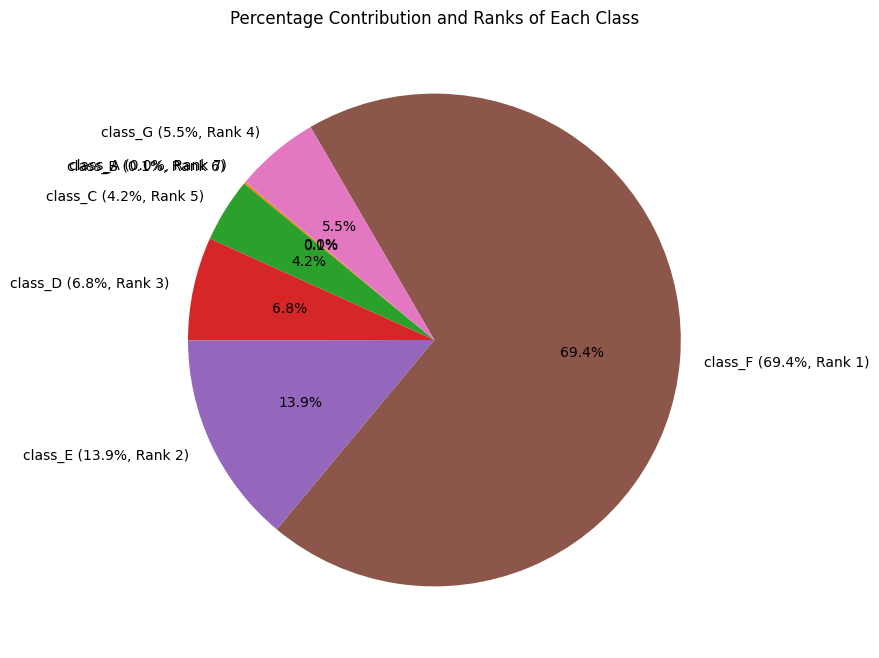

In [323]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.DataFrame({
    'Region': ['Central', 'East', 'South', 'West'],
    'class_A': [1, 1, 0, 1],
    'class_B': [4, 5, 3, 1],
    'class_C': [77, 126, 73, 144],
    'class_D': [164, 190, 111, 212],
    'class_E': [320, 391, 219, 462],
    'class_F': [1569, 1987, 1110, 2273],
    'class_G': [188, 148, 104, 110]
})

# Calculate total sales for each class
class_totals = df.iloc[:, 1:].sum(axis=0)

# Calculate percentage contributions for each class
class_percentages = (class_totals / class_totals.sum()) * 100

# Rank each class based on total sales
class_ranks = class_totals.rank(ascending=False).astype(int)

# Create labels with percentages and ranks
labels = [
    f"{col} ({class_percentages[i]:.1f}%, Rank {class_ranks[i]})"
    for i, col in enumerate(class_totals.index)
]

# Pie chart
plt.figure(figsize=(15, 8))
plt.pie(class_totals, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Percentage Contribution and Ranks of Each Class')
plt.show()


In [324]:
# Rank A - Selling Price - 10000 to 20000
# Rank B - Selling Price - 5000 to 9999
# Rank C - Selling Price - 1000 to 4999
# Rank D - Selling Price - 500 to 999
# Rank E - Selling Price - 200 to 499
# Rank F - Selling Price - 1 to 199
# Rank G - Selling Price - 0

# **2) Profit**

In [325]:
df_p=pd.read_csv('/content/class_profit.csv')
df_p

,Unnamed: 0,Region,class_A,class_B,class_C,class_D,class_E,class_F,class_G
0,0,Central,0,1,0,0,5,1188,1129
1,1,East,0,0,0,0,9,1563,1276
2,2,South,0,0,0,0,5,873,742
3,3,West,0,0,0,0,4,1817,1382


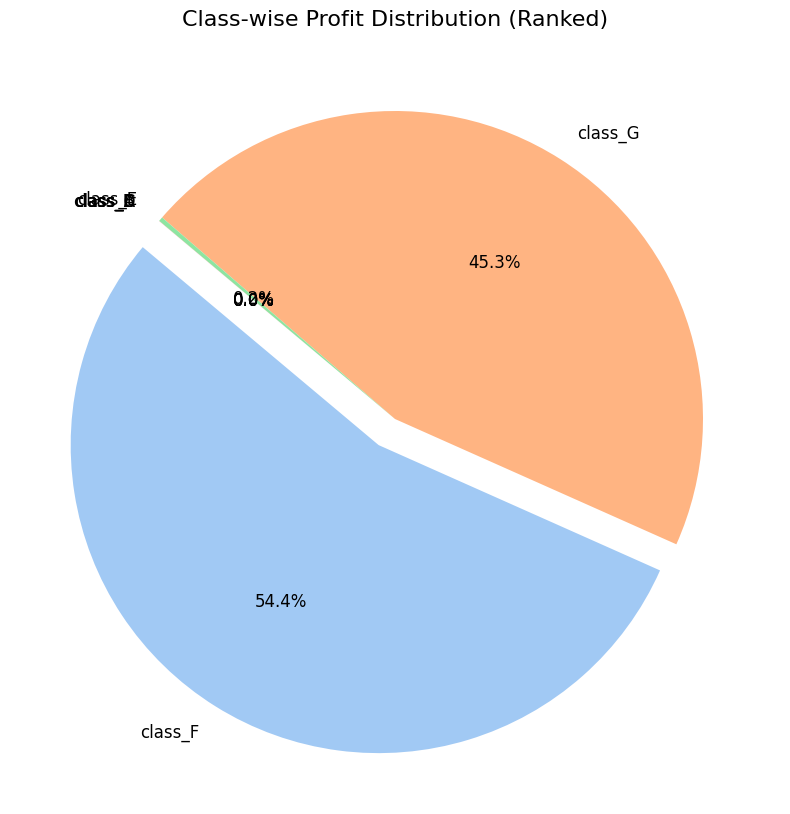

In [326]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
data = {
    "Region": ["Central", "East", "South", "West"],
    "class_A": [0, 0, 0, 0],
    "class_B": [1, 0, 0, 0],
    "class_C": [0, 0, 0, 0],
    "class_D": [0, 0, 0, 0],
    "class_E": [5, 9, 5, 4],
    "class_F": [1188, 1563, 873, 1817],
    "class_G": [1129, 1276, 742, 1382]
}
df_p = pd.DataFrame(data)

# Sum profits across regions for each class
class_totals = df_p.iloc[:, 1:].sum()

# Sort by total profit in descending order
class_totals = class_totals.sort_values(ascending=False)

# Plot the pie chart
plt.figure(figsize=(10, 10))  # Increased figure size for better visibility
colors = sns.color_palette("pastel")

# Optional: Explode the largest slice slightly for emphasis
explode = [0.1 if i == 0 else 0 for i in range(len(class_totals))]

# Generate the pie chart
plt.pie(class_totals, labels=class_totals.index, autopct='%1.1f%%',
        colors=colors, startangle=140, textprops={'fontsize': 12}, explode=explode)

# Add a clear title
plt.title("Class-wise Profit Distribution (Ranked)", fontsize=16)
plt.show()


In [327]:
# 3000 to 3624 class A
#2500 to 2999 class B
#2000 to 2499 class C
#1500 to 1999 class D
#500 to 1499 class E
#1 to 499 class F
# Else class G - 0 to -5

# **3) Quantity**

In [328]:
df_q=pd.read_csv('/content/class_quantity.csv')
df_q

,Unnamed: 0,Region,class_A,class_B,class_C,class_D,class_E,class_F,class_G
0,0,Central,2232,0,0,0,64,0,27
1,1,East,2724,0,0,0,83,0,41
2,2,South,1552,0,0,0,46,0,22
3,3,West,3058,0,0,0,94,0,51


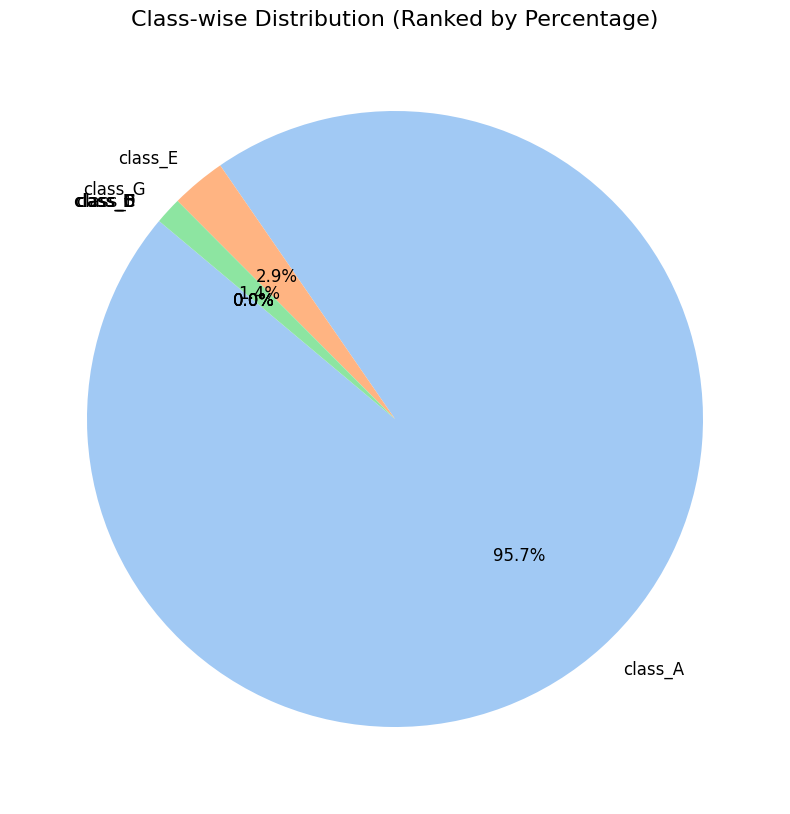

In [329]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
data = {
    "Region": ["Central", "East", "South", "West"],
    "class_A": [2232, 2724, 1552, 3058],
    "class_B": [0, 0, 0, 0],
    "class_C": [0, 0, 0, 0],
    "class_D": [0, 0, 0, 0],
    "class_E": [64, 83, 46, 94],
    "class_F": [0, 0, 0, 0],
    "class_G": [27, 41, 22, 51]
}
df = pd.DataFrame(data)

# Calculate total for each class across all regions
class_totals = df.iloc[:, 1:].sum()

# Calculate percentages
class_percentages = (class_totals / class_totals.sum()) * 100

# Rank classes by percentage
class_percentages = class_percentages.sort_values(ascending=False)

# Plot the pie chart
plt.figure(figsize=(10, 10))  # Set figure size for better readability
colors = sns.color_palette("pastel")  # Use Seaborn's pastel color palette

# Generate the pie chart
plt.pie(
    class_percentages,
    labels=class_percentages.index,
    autopct='%1.1f%%',
    colors=colors,
    startangle=140,
    textprops={'fontsize': 12}  # Increase font size for readability
)

# Add a title
plt.title("Class-wise Distribution (Ranked by Percentage)", fontsize=16)
plt.show()


In [330]:
# 12 to 14 class A
#10 to 11 class B
#8 to 9 class C
#6 to 7 class D
#3 to 5 class E
#1 to 2 class F
# Else class G

# **4) Discount**

In [331]:
df_d=pd.read_csv('/content/class_discount.csv')
df_d

,Unnamed: 0,Region,class_A,class_B,class_C,class_D,class_E,class_F,class_G
0,0,Central,0,0,1,1,2,2141,178
1,1,East,0,0,1,0,9,2703,135
2,2,South,0,0,0,0,3,1519,98
3,3,West,0,0,1,1,1,3103,97


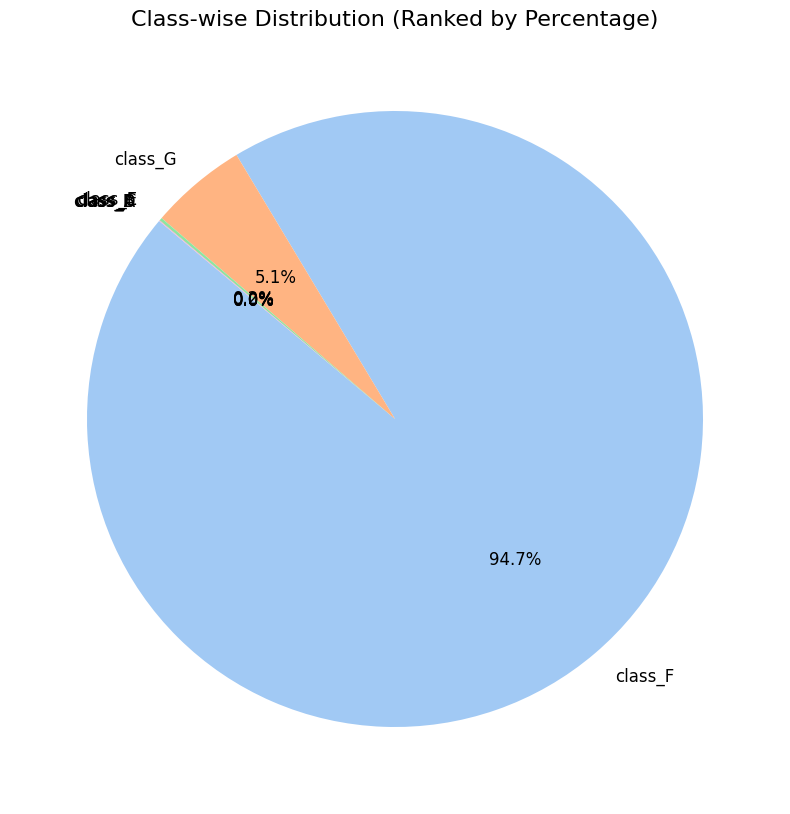

In [332]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
data = {
    "Region": ["Central", "East", "South", "West"],
    "class_A": [0, 0, 0, 0],
    "class_B": [0, 0, 0, 0],
    "class_C": [1, 1, 0, 1],
    "class_D": [1, 0, 0, 1],
    "class_E": [2, 9, 3, 1],
    "class_F": [2141, 2703, 1519, 3103],
    "class_G": [178, 135, 98, 97]
}
df = pd.DataFrame(data)

# Calculate total for each class across all regions
class_totals = df.iloc[:, 1:].sum()

# Calculate percentages for each class
class_percentages = (class_totals / class_totals.sum()) * 100

# Rank classes by percentage
class_percentages = class_percentages.sort_values(ascending=False)

# Plot the pie chart
plt.figure(figsize=(10, 10))  # Set figure size for better readability
colors = sns.color_palette("pastel")  # Use Seaborn's pastel color palette

# Generate the pie chart
plt.pie(
    class_percentages,
    labels=class_percentages.index,
    autopct='%1.1f%%',
    colors=colors,
    startangle=140,
    textprops={'fontsize': 12}  # Increase font size for readability
)

# Add a title
plt.title("Class-wise Distribution (Ranked by Percentage)", fontsize=16)
plt.show()


In [333]:
# 850 to 905.6 class A
#700 to 849 class B
#500 to 699 class C
#350 to 499 class D
#200 to 349 class E
#0.1 to 199 class F
# Else class G

In [334]:
query = f"SELECT * from {table_name};"
result = pd.read_sql_query(query, conn)

# Display the results
result.head(5)

,Unnamed: 0,Order_Id,Order_Date,Ship_Mode,Segment,Country,City,State,Postal_Code,Region,...,Discount,Profit,year,month,day,Month_name,class_sales,class_profit,class_quantity,class_discount
0,0,1,2023-03-01,Second Class,Consumer,United States,Henderson,Kentucky,42420,South,...,5.2,14.8,2023,3,1,March,E,F,A,F
1,1,2,2023-08-15,Second Class,Consumer,United States,Henderson,Kentucky,42420,South,...,21.9,108.1,2023,8,15,August,D,F,A,F
2,2,3,2023-01-10,Second Class,Corporate,United States,Los Angeles,California,90036,West,...,0.5,-0.5,2023,1,10,January,F,G,A,F
3,3,4,2022-06-18,Standard Class,Consumer,United States,Fort Lauderdale,Florida,33311,South,...,19.2,160.8,2022,6,18,June,D,F,A,F
4,4,5,2022-07-13,Standard Class,Consumer,United States,Fort Lauderdale,Florida,33311,South,...,1.0,-1.0,2022,7,13,July,F,G,A,F


In [335]:
result.to_csv('cleaned-orders-1-class.csv')

In [336]:
df=pd.read_csv('/content/cleaned-orders-1-class.csv')
df.head(5)

,Unnamed: 0.1,Unnamed: 0,Order_Id,Order_Date,Ship_Mode,Segment,Country,City,State,Postal_Code,...,Discount,Profit,year,month,day,Month_name,class_sales,class_profit,class_quantity,class_discount
0,0,0,1,2023-03-01,Second Class,Consumer,United States,Henderson,Kentucky,42420,...,5.2,14.8,2023,3,1,March,E,F,A,F
1,1,1,2,2023-08-15,Second Class,Consumer,United States,Henderson,Kentucky,42420,...,21.9,108.1,2023,8,15,August,D,F,A,F
2,2,2,3,2023-01-10,Second Class,Corporate,United States,Los Angeles,California,90036,...,0.5,-0.5,2023,1,10,January,F,G,A,F
3,3,3,4,2022-06-18,Standard Class,Consumer,United States,Fort Lauderdale,Florida,33311,...,19.2,160.8,2022,6,18,June,D,F,A,F
4,4,4,5,2022-07-13,Standard Class,Consumer,United States,Fort Lauderdale,Florida,33311,...,1.0,-1.0,2022,7,13,July,F,G,A,F


In [341]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 30 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Unnamed: 0.1      9994 non-null   int64         
 1   Unnamed: 0        9994 non-null   int64         
 2   Order_Id          9994 non-null   int64         
 3   Order_Date        9994 non-null   datetime64[ns]
 4   Ship_Mode         9994 non-null   object        
 5   Segment           9994 non-null   object        
 6   Country           9994 non-null   object        
 7   City              9994 non-null   object        
 8   State             9994 non-null   object        
 9   Postal_Code       9994 non-null   int64         
 10  Region            9994 non-null   object        
 11  Category          9994 non-null   object        
 12  Sub_Category      9994 non-null   object        
 13  Product_Id        9994 non-null   object        
 14  cost_price        9994 n

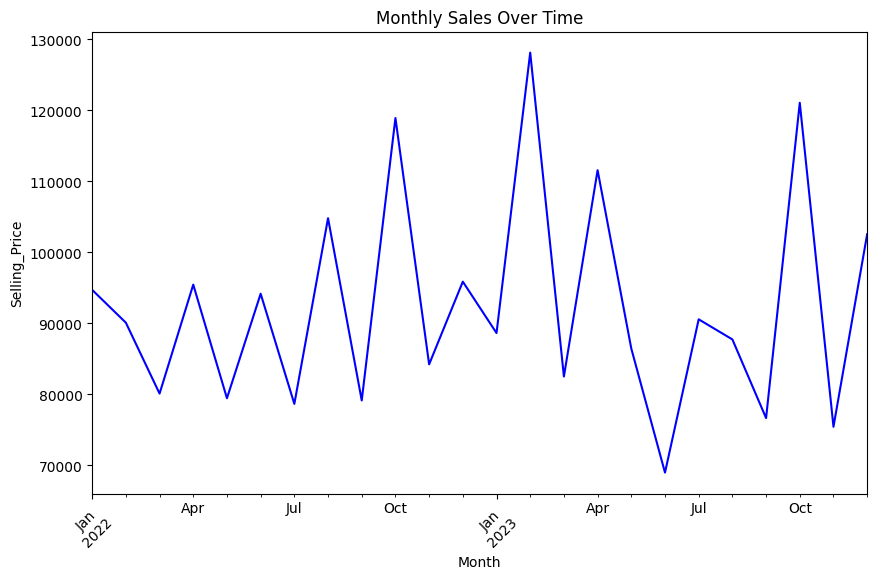

In [339]:
df['Order_Date'] = pd.to_datetime(df['Order_Date'])

# Group by year and month for sales
df['year_month'] = df['Order_Date'].dt.to_period('M')
monthly_sales = df.groupby('year_month')['Selling_Price'].sum()

# Plot the data
plt.figure(figsize=(10,6))
monthly_sales.plot(kind='line', color='blue')
plt.title('Monthly Sales Over Time')
plt.xlabel('Month')
plt.ylabel('Selling_Price')
plt.xticks(rotation=45)
plt.show()


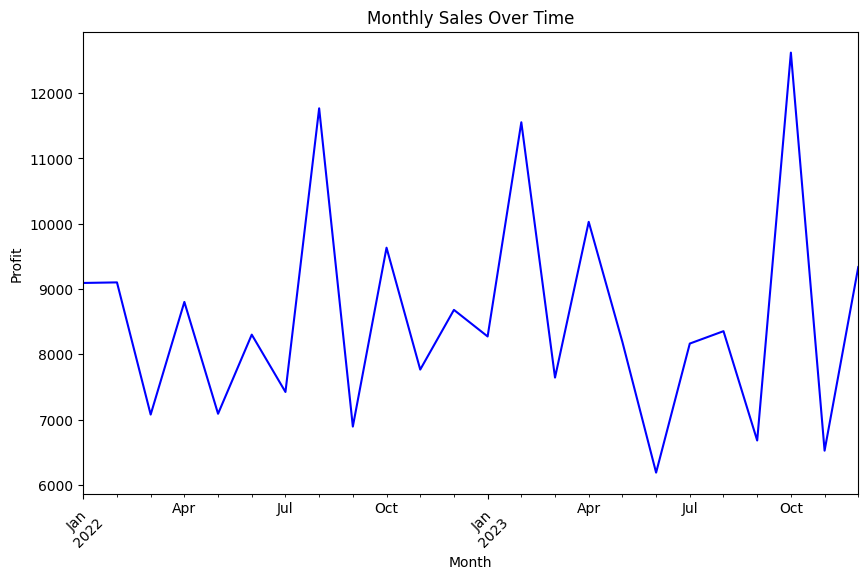

In [340]:
df['Order_Date'] = pd.to_datetime(df['Order_Date'])

# Group by year and month for sales
df['year_month'] = df['Order_Date'].dt.to_period('M')
monthly_sales = df.groupby('year_month')['Profit'].sum()

# Plot the data
plt.figure(figsize=(10,6))
monthly_sales.plot(kind='line', color='blue')
plt.title('Monthly Sales Over Time')
plt.xlabel('Month')
plt.ylabel('Profit')
plt.xticks(rotation=45)
plt.show()


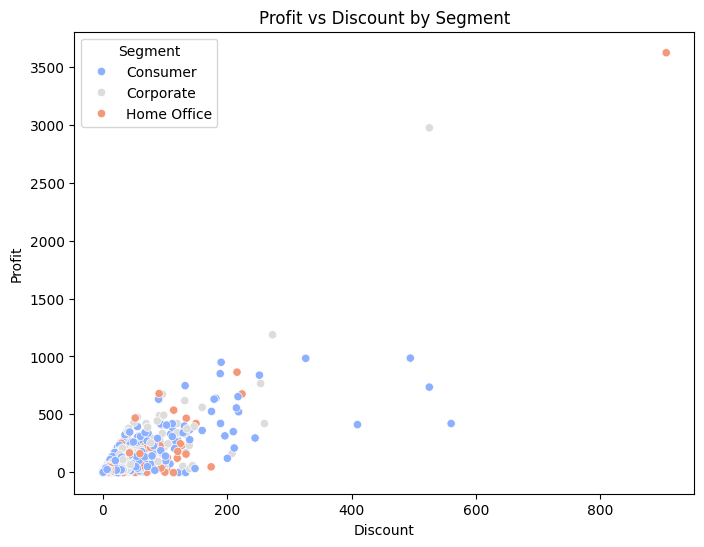

In [342]:
# Scatter plot for Profit vs Discount
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='Discount', y='Profit', hue='Segment', palette='coolwarm')
plt.title('Profit vs Discount by Segment')
plt.xlabel('Discount')
plt.ylabel('Profit')
plt.show()


<ipython-input-344-44e0c82d722b>:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='Segment', y='Selling_Price', estimator=sum, ci=None)


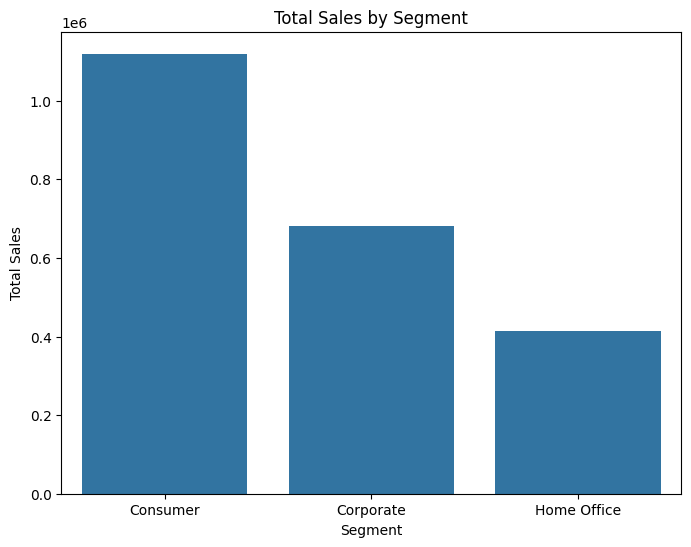

In [344]:
# Sales by Segment bar plot
plt.figure(figsize=(8,6))
sns.barplot(data=df, x='Segment', y='Selling_Price', estimator=sum, ci=None)
plt.title('Total Sales by Segment')
plt.xlabel('Segment')
plt.ylabel('Total Sales')
plt.show()


# **Correlation heatmap**

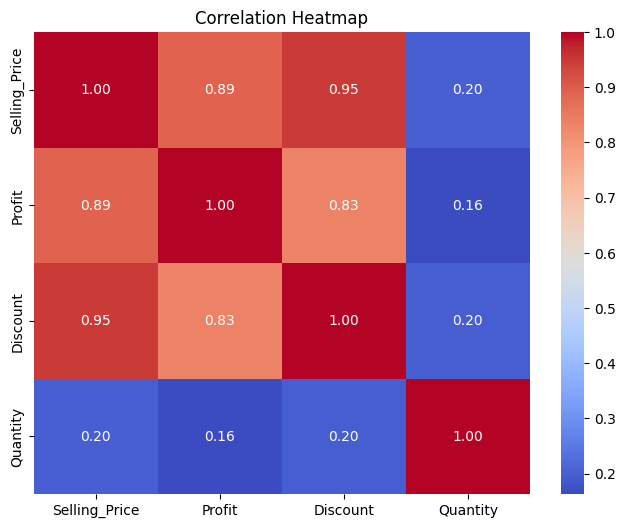

In [346]:
# Calculate correlations
corr = df[['Selling_Price', 'Profit', 'Discount', 'Quantity']].corr()

# Heatmap of correlations
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()


<ipython-input-348-26d127449aba>:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='Region', y='Selling_Price', estimator=sum, ci=None)


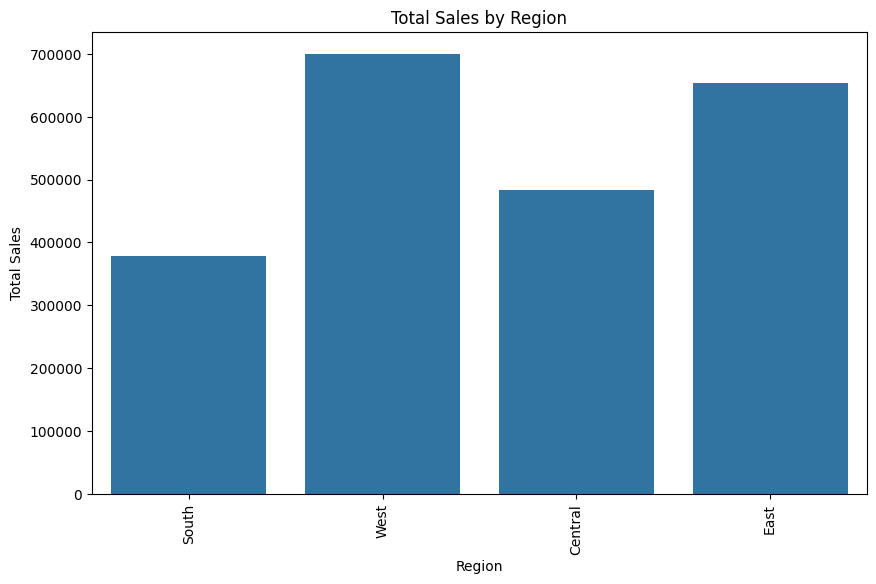

In [348]:
# Sales by Country bar plot
plt.figure(figsize=(10,6))
sns.barplot(data=df, x='Region', y='Selling_Price', estimator=sum, ci=None)
plt.title('Total Sales by Region')
plt.xlabel('Region')
plt.ylabel('Total Sales')
plt.xticks(rotation=90)
plt.show()


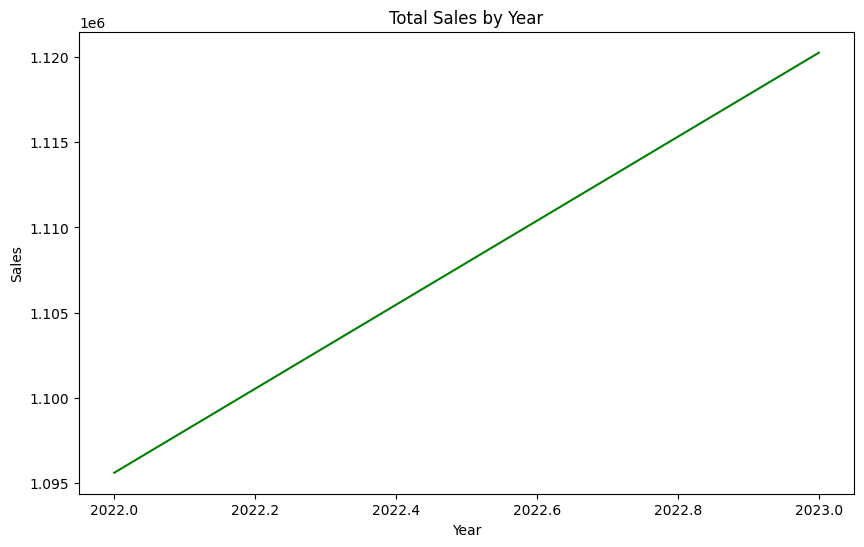

In [350]:
# Group data by year
yearly_sales = df.groupby('year')['Selling_Price'].sum()

# Plot yearly sales
plt.figure(figsize=(10,6))
yearly_sales.plot(kind='line', color='green')
plt.title('Total Sales by Year')
plt.xlabel('Year')
plt.ylabel('Sales')
plt.show()


# **this is Posative Regression**

In [351]:
#######################################################################################################